# Analisis beam blockage para diferentes ángulos de elevación

Este cuaderno mostrará las zonas en las cuales el haz del radar es bloqueado por algún obstáculo del relieve topográfico. Como tal este cuaderno no es más que una adaptación del cuaderno de Wradlib para calcular el bloqueo del haz, sólo que posee los datos de Piura en su lugar.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Filtramos las advertencias
import warnings
warnings.filterwarnings('ignore')

Necesitamos datos acerca de la posición geográfica del radar así como de algunas de sus características.

In [2]:
sitecoords = (-80.63895, -5.17044, 56)
nrays = 360 # Número de rayos
nbins = 1000 # Número de divisiones del rango
bw = 1.0 # Medio ancho del angulo de barrido (deg)
range_res = 100. # Resolución del rango (meters)

Usaremos 4 ángulos de elevación(0°, 1°, 2° y 3°)

In [3]:
el_list = [0,1,2,3]

Con los datos construimos el vector de distancias(que corresponde al r ya visto en los módulos, solo que en metros.)

In [4]:
r = np.arange(nbins) * range_res

Calculamos "bw". Detalles en el cuaderno Bloqueo del haz.

In [5]:
beamradius = wrl.util.half_power_radius(r, bw)

Agregamos el DEM a utilizar. 

In [6]:
raster = 'C:/Users/Elmer Lopez Ramirez/Downloads/RadarPiuraDEM.tif'

Creamos una función para calcular la fracción bloqueada de cada compartimiento. Se suele denominar acumulada pues el procedimiento toma en cuenta que los valores a lo largo de un haz no pueden ser menores a sus antecesores. 

In [7]:
def cumulative_beam_blockage(el,raster):
    # Proyección de los datos 
    coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
    coords = wrl.georef.spherical_to_proj(coord[..., 0], np.degrees(coord[..., 1]), coord[..., 2], sitecoords)
    lon = coords[..., 0]
    lat = coords[..., 1]
    alt = coords[..., 2]
    polcoords = coords[...,:2]
    rlimits = (lon.min(),lat.min(),lon.max(),lat.max())
    # DEM
    ds = wrl.io.gdal.open_raster(raster)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)
    # Recortamos los datos 
    ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
    rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
    rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]
    polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues, polcoords, order=3, prefilter=False)
    # Calculamos el la fracción afectada por el bloqueo del haz y el "acumulado correspondiente"
    PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
    PBB = np.ma.masked_invalid(PBB)
    CBB = wrl.qual.cum_beam_block_frac(PBB)
    return coord, CBB

Y una pequeña función más para graficar los resultados.

In [8]:
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilómetros")
    ax.set_ylabel("Kilómetros")
    if not cm is None:
        plt.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

Mostramos los resultados

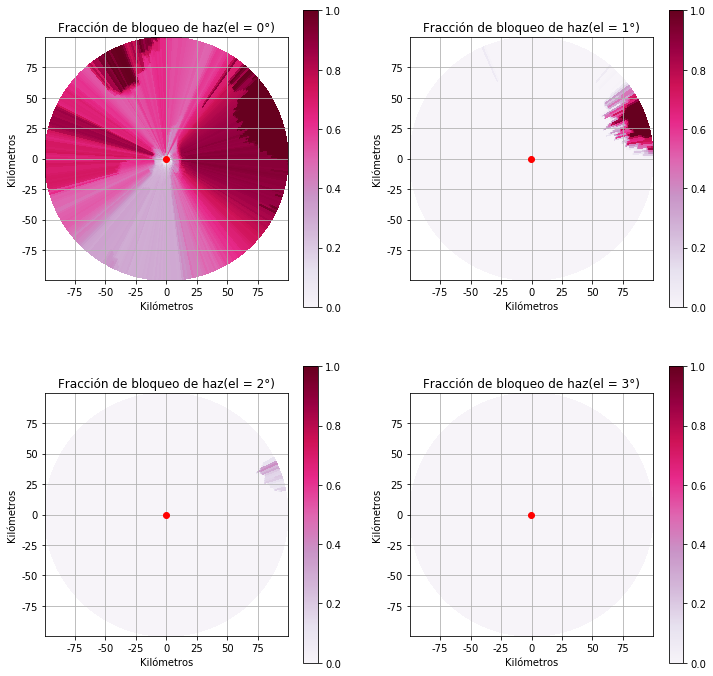

In [10]:
# Figura
fig = plt.figure(figsize=(12, 12))

# Agregamos las sub-gráficas
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

axis = [ax1, ax2, ax3, ax4]

# Resultados del CBB
for i in range(4):
    coord, CBB = cumulative_beam_blockage(el_list[i], raster)
    ax, cbb = wrl.vis.plot_ppi(CBB, ax=axis[i], r=r, az=np.degrees(coord[:,0,1]), cmap=mpl.cm.PuRd, vmin=0, vmax=1)
    ax.plot(sitecoords[0], sitecoords[1], 'ro')
    annotate_map(ax, cbb, title = 'Fracción de bloqueo de haz(el = {}°)'.format(el_list[i]))
